In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import folium
import os
from datetime import datetime, timedelta
print(os.getcwd())

C:\Users\gijsd\Google Drive\Uni\AT year 3\Bachelor Assignment\thesis_code\research_questions\rq1


In [34]:
def processDataFrame(df):
    df['timeStamp'] = df['timeStamp'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f'))
    start_time = df['timeStamp'].iloc[0]
    df['Time (s)'] = (df['timeStamp'] - start_time).dt.total_seconds()
    total_time = df['Time (s)'].iloc[-1]
    fs = len(df)/total_time # Sampling frequency of Thingy, should be 200 Hz
    print("Total elapsed time: {:.2f} seconds".format(total_time))
    print(f'Sample frequency of Thingy = {fs} Hz')
    return fs

Data import and formatting

In [35]:
df = pd.read_csv('data/P1Cruise2_04-05-2023 13-48-07.550.csv', header=None)
df.columns = ['timeStamp',
              'xa','ya','za',
              'verticalAcc','averageHighestAcc','averageLowestAcc', #TODO: useful?
              'xa_cal','ya_cal','za_cal', # Calibrated Thingy:52 accelerometer
              'xg','yg','zg', # Thingy:52 gyroscope
              'currentSpeed','distance',
              'mLocationLat','mLocationLong',
              'mAcc_0','mAcc_1','mAcc_2', # Phone acc is in m/s^2 according to android studio
              'mAcc_cal_0','mAcc_cal_1','mAcc_cal_2', #calibrated phone accelerometer
              'mGyr_0','mGyr_1','mGyr_2'] # Phone gyr is in rad/s according to android studio
# Fixing time and time interval of interest
fs = processDataFrame(df)

#P1 configurtation, align cordinates of phone to thingy, dimension sync
df['mAcc_1'], df['mAcc_0'], df['mAcc_cal_1'], df['mAcc_cal_0'] = -df['mAcc_0'], -df['mAcc_1'], -df['mAcc_cal_0'], -df['mAcc_cal_1']
df['xg'], df['yg'], df['zg'] = df['yg'], df['xg'], -df['zg']

#TODO: Find time interval where maneuver occurs -> look at angle

time_interval = (df['Time (s)'] >= 5) & (df['Time (s)'] < 6) #Default
#time_interval = (df['Time (s)'] >= 3.8) & (df['Time (s)'] < 15) #P1SharpRight
#time_interval = (df['Time (s)'] >= 8) & (df['Time (s)'] < 14) #P1SharpRight2
#time_interval = (df['Time (s)'] >= 11) & (df['Time (s)'] < 21) #P1SharpLeft3 #Left Turn Example
#time_interval = (df['Time (s)'] >= 4) & (df['Time (s)'] < 13) #P1SharpLeft
#time_interval = (df['Time (s)'] >= 8) & (df['Time (s)'] < 15) #P1SharpLeft2
#time_interval = (df['Time (s)'] >= 10) & (df['Time (s)'] < 17) #P1Cruise
#time_interval = (df['Time (s)'] >= 2) & (df['Time (s)'] < 11) #P1UTurnRight
#time_interval = (df['Time (s)'] >= 10) & (df['Time (s)'] < 20) #P1UTurnRight
#time_interval = (df['Time (s)'] >= 183) & (df['Time (s)'] < 193) #P1RouteRandom

df = df[time_interval]

#print(df)


Total elapsed time: 37.42 seconds
Sample frequency of Thingy = 196.51495309618622 Hz


Accelerometers

Sample frequency of mAcc = 39.41908713692944
Sample frequency of mGyr = 41.49377593360994


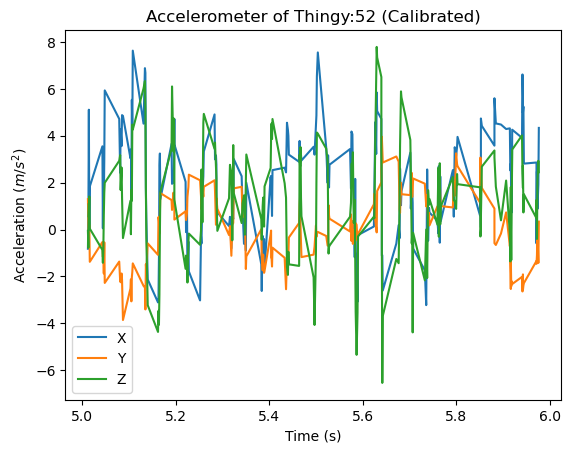

avg acceleration: 2.0641238452909687, 0.10275844259268745, 1.2023672339312181
 phone: -0.8649748338421054, -0.043424228263157894, -0.28598219823684207 


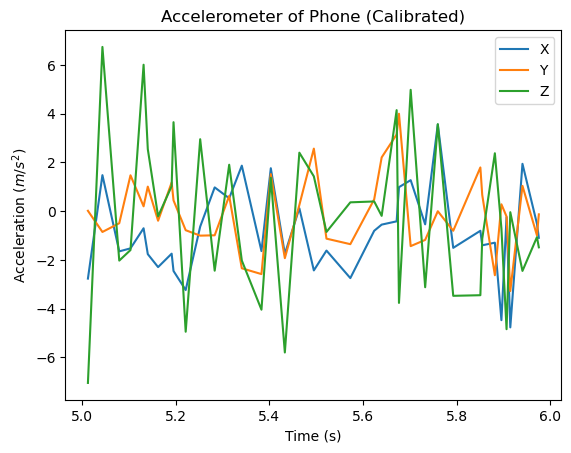

In [36]:
gravity_fac = 9.81
acc_x = df['xa_cal']*gravity_fac# - np.mean(df['xa']) # Optionally: Remove DC offset
acc_y = df['ya_cal']*gravity_fac
acc_z = df['za_cal']*gravity_fac
mAcc = df.dropna(subset=['mAcc_0','mAcc_1','mAcc_2','mAcc_cal_0','mAcc_cal_1','mAcc_cal_2'])[['Time (s)', 'mAcc_0','mAcc_1','mAcc_2','mAcc_cal_0','mAcc_cal_1','mAcc_cal_2']]
mGyr = df.dropna(subset=['mGyr_0','mGyr_1','mGyr_2'])[['Time (s)', 'mGyr_0','mGyr_1','mGyr_2']]

# Sampling frequency
fs_phone_acc = len(mAcc)/(mAcc['Time (s)'].iloc[-1] - df['Time (s)'].iloc[0])
fs_phone_gyr = len(mGyr)/(mGyr['Time (s)'].iloc[-1] - df['Time (s)'].iloc[0])

print(f'Sample frequency of mAcc = {fs_phone_acc}\nSample frequency of mGyr = {fs_phone_gyr}')
#TODO: Noise removal of acceleration so it clearer to visualise -> LPF
#TODO: also noise removal for gyroscope, road vibrations annoying?

plt.plot(df['Time (s)'], acc_x, label='X')
plt.plot(df['Time (s)'], acc_y, label='Y')
plt.plot(df['Time (s)'], acc_z, label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Acceleration ($m/s^2$)'), plt.title('Accelerometer of Thingy:52 (Calibrated)'), plt.legend(loc='best')
plt.show()

mean_phone_x = mAcc['mAcc_cal_0'].mean()
mean_phone_y = mAcc['mAcc_cal_1'].mean()
mean_phone_z = mAcc['mAcc_cal_2'].mean()
print(f'avg acceleration: {acc_x.mean()}, {acc_y.mean()}, {acc_z.mean()}\n phone: {mean_phone_x}, {mean_phone_y}, {mean_phone_z} ')
plt.plot(mAcc['Time (s)'], mAcc['mAcc_cal_0'], label='X')
plt.plot(mAcc['Time (s)'], mAcc['mAcc_cal_1'], label='Y')
plt.plot(mAcc['Time (s)'], mAcc['mAcc_cal_2'], label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Acceleration ($m/s^2$)'), plt.title('Accelerometer of Phone (Calibrated)'), plt.legend(loc='best')
plt.show()

Gyroscopes

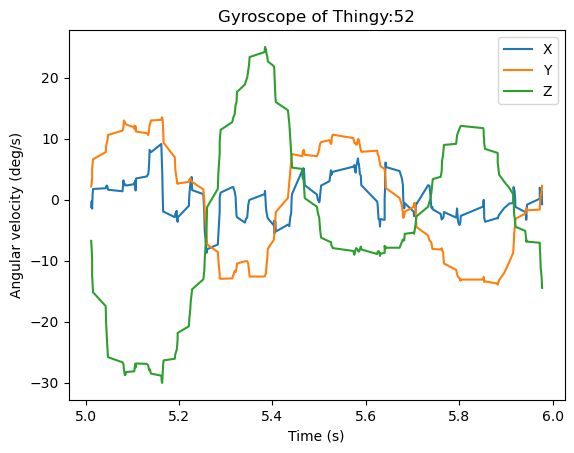

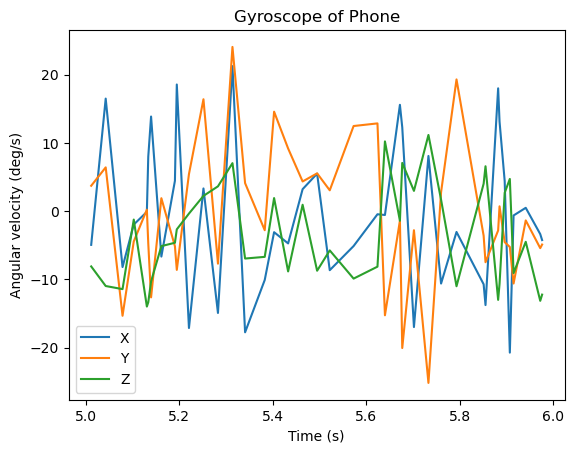

In [37]:
gyr_x = df['xg']
gyr_y = df['yg']
gyr_z = df['zg']
phone_gyr_x = mGyr['mGyr_0'] * 180 / math.pi
phone_gyr_y = mGyr['mGyr_1'] * 180 / math.pi
phone_gyr_z = mGyr['mGyr_2'] * 180 / math.pi

#Thingy gyroscope
plt.plot(df['Time (s)'], gyr_x, label='X')
plt.plot(df['Time (s)'], gyr_y, label='Y')
plt.plot(df['Time (s)'], gyr_z, label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angular velocity (deg/s)'), plt.title('Gyroscope of Thingy:52'), plt.legend(loc='best')
plt.show()

#Phone gyroscope
plt.plot(mGyr['Time (s)'], phone_gyr_x, label='X')
plt.plot(mGyr['Time (s)'], phone_gyr_y, label='Y')
plt.plot(mGyr['Time (s)'], phone_gyr_z, label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angular velocity (deg/s)'), plt.title('Gyroscope of Phone'),plt.legend(loc='best')
plt.show()

Angle data

t_m for this maneuver: 5.977


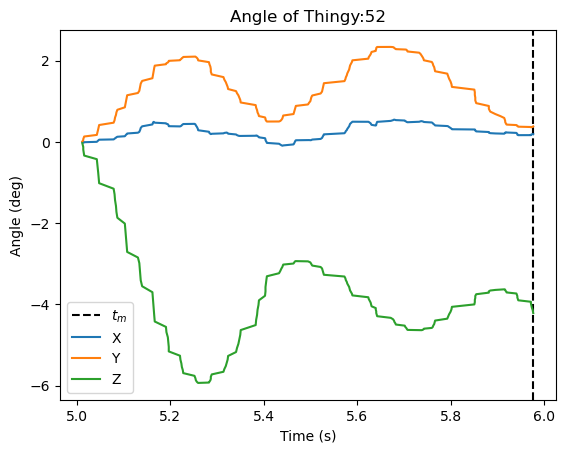

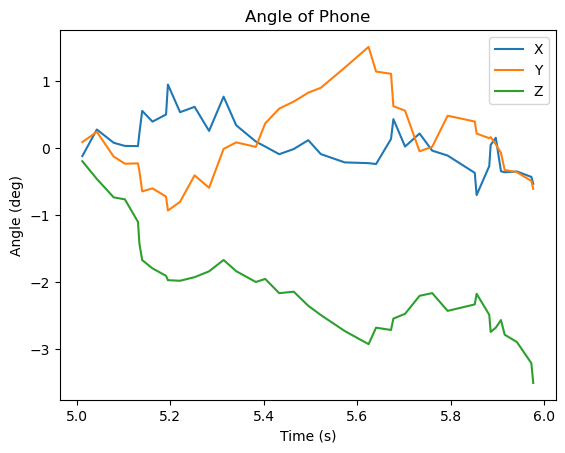

In [38]:
# Compute the cumulative sum of the gyroscope data for each dimension to get the angle
angle_x = np.cumsum(gyr_x)*(1/fs)
angle_y = np.cumsum(gyr_y)*(1/fs)
angle_z = np.cumsum(gyr_z)*(1/fs)
phone_angle_x = np.cumsum(phone_gyr_x) * (1 / fs_phone_gyr) #phone angle x
phone_angle_y = np.cumsum(phone_gyr_y) * (1 / fs_phone_gyr)
phone_angle_z = np.cumsum(phone_gyr_z) * (1 / fs_phone_gyr)

# Find the index of the last point that crosses the time-axis
crossings = (angle_z.shift(1) >= 0) != (angle_z >= 0)
last_crossing_time = df.loc[crossings[::-1].idxmax(), 'Time (s)']
plt.axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
print(f't_m for this maneuver: {last_crossing_time}')

# Plot the Thingy:52 angles
#TODO: Figure out if angle is affected when braking
plt.plot(df['Time (s)'], angle_x, label='X')# Tilt of bike
plt.plot(df['Time (s)'], angle_y, label='Y')# Driving up and downhill
plt.plot(df['Time (s)'], angle_z, label='Z')# Direction of bike
plt.xlabel('Time (s)'), plt.ylabel('Angle (deg)'), plt.title('Angle of Thingy:52'), plt.legend(loc='best')
plt.show()

# Plot the phone angles
plt.plot(mGyr['Time (s)'], phone_angle_x, label='X')
plt.plot(mGyr['Time (s)'], phone_angle_y, label='Y')
plt.plot(mGyr['Time (s)'], phone_angle_z, label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angle (deg)'), plt.title('Angle of Phone'), plt.legend(loc='best')
plt.show()

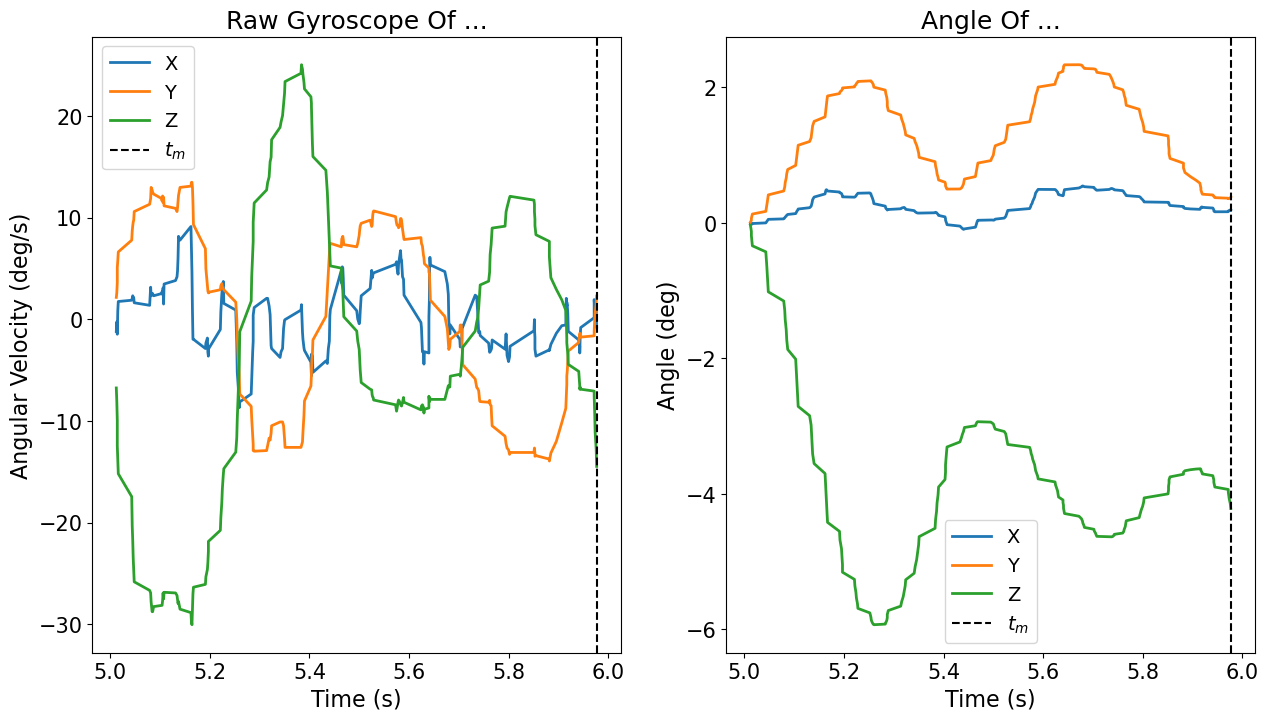

In [39]:
%matplotlib inline
# Pops out figures
# Create a figure object with 2 subplots for Thingy gyroscope
fig1, axs1 = plt.subplots(1, 2, figsize=(15, 8))
axs1[0].plot(df['Time (s)'], gyr_x, label='X', linewidth=2)
axs1[0].plot(df['Time (s)'], gyr_y, label='Y', linewidth=2)
axs1[0].plot(df['Time (s)'], gyr_z, label='Z', linewidth=2)
axs1[0].axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
axs1[0].set_xlabel('Time (s)', fontsize=16), axs1[0].set_ylabel('Angular Velocity (deg/s)', fontsize=16), axs1[0].set_title('Raw Gyroscope Of ...', fontsize=18), axs1[0].legend(loc='best', fontsize=14)
axs1[0].tick_params(axis='both', which='major', labelsize=15)
axs1[1].plot(df['Time (s)'], angle_x, label='X', linewidth=2) # Tilt of bike
axs1[1].plot(df['Time (s)'], angle_y, label='Y', linewidth=2) # Driving up and downhill
axs1[1].plot(df['Time (s)'], angle_z, label='Z', linewidth=2) # Direction of bike
axs1[1].axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
axs1[1].set_xlabel('Time (s)', fontsize=16), axs1[1].set_ylabel('Angle (deg)', fontsize=16), axs1[1].set_title('Angle Of ...', fontsize=18), axs1[1].legend(loc='best', fontsize=14)
axs1[1].tick_params(axis='both', which='major', labelsize=15)
plt.show()

#TODO: Optional, drift noise removel by DC offset removal, by HPF
# Create a figure object with 2 subplots for Phone gyroscope
# fig2, axs2 = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
# axs2[0].plot(mGyr['Time (s)'], phone_gyr_x, label='X')
# axs2[0].plot(mGyr['Time (s)'], phone_gyr_y, label='Y')
# axs2[0].plot(mGyr['Time (s)'], phone_gyr_z, label='Z')
# axs2[0].set_ylabel('Angular velocity (deg/s)')
# axs2[0].set_title('Gyroscope of Phone')
# axs2[0].legend(loc='best')
#
# axs2[1].plot(mGyr['Time (s)'], phone_angle_x, label='X')
# axs2[1].plot(mGyr['Time (s)'], phone_angle_y, label='Y')
# axs2[1].plot(mGyr['Time (s)'], phone_angle_z, label='Z')
# axs2[1].set_xlabel('Time (s)')
# axs2[1].set_ylabel('Angle (deg)')
# axs2[1].set_title('Angle of Phone')
# axs2[1].legend(loc='best')
#
# plt.show()

GPS map

In [40]:
%matplotlib inline
# Remove consecutive duplicate values in column 'B'
# df.loc[df['mLocationLong'] == df['mLocationLong'].shift(1), 'mLocationLong'] = np.nan
# df.loc[df['mLocationLat'] == df['mLocationLat'].shift(1), 'mLocationLat'] = np.nan

gps = df.dropna(subset=['mLocationLat', 'mLocationLong','currentSpeed','distance'])[['Time (s)', 'mLocationLat', 'mLocationLong','currentSpeed','distance']]
print(gps)

#TODO: optional get distance travelled from long and lat
# Create a map object centered on the mean of the lat and long columns
my_map = folium.Map(location=[gps['mLocationLat'].mean(), gps['mLocationLong'].mean()], zoom_start=12, width='100%', height='100%')

# Add markers for each lat-long pair
for index, row in gps.iterrows():
    folium.Marker([row['mLocationLat'], row['mLocationLong']]).add_to(my_map)

# Add a polyline to the map with the lat-long pairs from the DataFrame
locations = list(zip(gps['mLocationLat'], gps['mLocationLong']))
folium.PolyLine(locations=locations, color='red').add_to(my_map)

# Display the map
my_map

      Time (s)  mLocationLat  mLocationLong  currentSpeed  distance
990      5.012      52.24048       6.896285        11.160   7.32507
991      5.013      52.24048       6.896285        11.160   7.32507
992      5.014      52.24048       6.896285        11.160   7.32507
993      5.014      52.24048       6.896285        11.160   7.32507
994      5.015      52.24048       6.896285        11.160   7.32507
...        ...           ...            ...           ...       ...
1177     5.972      52.24048       6.896285        14.832  11.38739
1178     5.973      52.24048       6.896285        14.832  11.38739
1179     5.974      52.24048       6.896285        14.832  11.38739
1180     5.976      52.24048       6.896285        14.832  11.38739
1181     5.977      52.24048       6.896285        14.832  11.38739

[192 rows x 5 columns]


Distance as calculated by long and lat

In [41]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    # convert to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # calculate haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # radius of earth in kilometers
    return c * r * 1000  # return distance in meters

# assuming your DataFrame is called "gps" and has columns "mLocationLat" and "mLocationLong"
distance = 0
for i in range(1, len(gps)):
    lat1, lon1 = gps.iloc[i-1]['mLocationLat'], gps.iloc[i-1]['mLocationLong']
    lat2, lon2 = gps.iloc[i]['mLocationLat'], gps.iloc[i]['mLocationLong']
    distance += haversine(lat1, lon1, lat2, lon2)

print(f"Total distance travelled: {distance} meters")
print(f"Distance as calculated by app: {gps['distance'].iloc[-1]}")


Total distance travelled: 0.0 meters
Distance as calculated by app: 11.38738986337185
